In [17]:
# This is a Python 3 environment

# Base level imports for data science work
import numpy as np 
import pandas as pd
import re,string,unicodedata
import os
from os import path
from json import decoder
import glob, os, json
import re

# Visualization Libs
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP Libs
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Additional Libs
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

# Deep Learning Libs
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
df_BA = pd.read_csv("https://chruezfalsch.ch/df_ba_cleaned.csv")
df_BA = df_BA[df_BA['text'].str.split().str.len().lt(3500)]
df_BA = df_BA[df_BA['text'].str.split().str.len().gt(400)]
del df_BA['Unnamed: 0'] 

In [20]:
df_val = df_BA[df_BA.fake == 0].sample(50)
df_val = df_val.append(df_BA[df_BA.fake == 1].sample(50))
df_BA = df_BA.drop(df_val.index)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

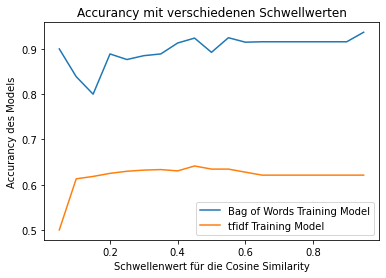

In [ ]:
def calclen(df1):
  results_bag=pd.DataFrame()
  results_tfidf=pd.DataFrame()
  for z in range(5,100,5):
    df_faketext=df1[df1.fake == 1]
    df_realtext=df1[df1.fake == 0]
    df_faketext=df_faketext.reset_index()
    df_realtext=df_realtext.reset_index()
    faketext=df_faketext.text
    realtext=df_realtext.text
      #########
    indnex_realtext=df_realtext.index
    indnex_faketext=df_faketext.index
    q=z/100
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(faketext)
    arr = X.toarray()
    cosinsimilarity_fake=cosine_similarity(arr)
    i=0
    b=0
    dd=0
    remover=[]

    for bla in  cosinsimilarity_fake:
        b=0
        if indnex_faketext[i] not in remover:
          for ba in bla:
            if b!=i:
              if ba>q:
                if indnex_faketext[b] not in remover:
                  remover.append(indnex_faketext[b])
            b=b+1
        i=i+1
    for dd in remover:
      #print(dd)
      df_faketext=df_faketext.drop(dd)

    #print(len(remover), "Werte wurden entfernt.", "es wurden foglende Werte entfernt")

    df_diff_ = df_faketext

    X = vectorizer.fit_transform(realtext)
    arr = X.toarray()
    cosinsimilarity_real=cosine_similarity(arr)
    i=0
    b=0
    dd=0
    del remover[:]
    remover=[]

    for bla in  cosinsimilarity_real:
        b=0
        if indnex_realtext[i] not in remover:
          for ba in bla:
            if b!=i:
              if ba>q:
                if indnex_realtext[b] not in remover:
                  remover.append(indnex_realtext[b])
            b=b+1
        i=i+1
    for dd in remover:
      df_realtext=df_realtext.drop(dd)

    #print(len(remover), "Werte wurden entfernt")
    df_diff_ = df_diff_.append(df_realtext)

    del remover[:]
    X = df_diff_.text
    y = df_diff_.fake
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8,stratify=y, random_state=19)
    cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
    cv_train=cv.fit_transform(X_train)
    cv_test=cv.transform(X_test)
    tfidf=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
    tfidf_train=tfidf.fit_transform(X_train)
    tfidf_test=tfidf.transform(X_test)
    mnb = MultinomialNB()
    mnb_cv = mnb.fit(cv_train, y_train)
    mnb_tfidf = mnb.fit(tfidf_train, y_train)
    mnb_cv_predict=mnb.predict(cv_test)
    mnb_tfidf_predict=mnb.predict(tfidf_test)
    mnb_cv_score=accuracy_score(y_test, mnb_cv_predict)
    mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
    mnb_cv_report = classification_report(y_test, mnb_cv_predict, target_names = ['0','1'])
    results_bag=results_bag.append({'len': q, 'accurancy': mnb_cv_score},ignore_index=True)
    mnb_tfidf_report = classification_report(y_test, mnb_tfidf_predict, target_names = ['0','1'])
    results_tfidf=results_tfidf.append({'len': q, 'accurancy': mnb_tfidf_score},ignore_index=True)

  
  # importing the required modules
  import matplotlib.pyplot as plt
  import numpy as np
  

  y3 = results_bag['accurancy']
  x3 = results_bag['len']
  plt.plot(x3, y3, label = "Bag of Words Training Model")

  y4 = results_tfidf['accurancy']
  x4 = results_tfidf['len']
  plt.plot(x4, y4, label = "tfidf Training Model")

  plt.xlabel("Schwellenwert für die Cosine Similarity")
  plt.ylabel("Accurancy des Models")

  plt.title('Accurancy mit verschiedenen Schwellwerten')
  plt.legend()
  plt.show()
  

calclen(df_BA)

# Validation

In [ ]:
def validate(df1,df2,threshold):
  results_bag=pd.DataFrame()
  results_tfidf=pd.DataFrame()
  df_faketext=df1[df1.fake == 1]
  df_realtext=df1[df1.fake == 0]
  df_faketext=df_faketext.reset_index()
  df_realtext=df_realtext.reset_index()
  faketext=df_faketext.text
  realtext=df_realtext.text
      #########
  indnex_realtext=df_realtext.index
  indnex_faketext=df_faketext.index
  q=threshold
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(faketext)
  arr = X.toarray()
  cosinsimilarity_fake=cosine_similarity(arr)
  i=0
  b=0
  dd=0
  remover=[]

  for bla in  cosinsimilarity_fake:
      b=0
      if indnex_faketext[i] not in remover:
        for ba in bla:
          if b!=i:
            if ba>q:
              if indnex_faketext[b] not in remover:
                remover.append(indnex_faketext[b])
          b=b+1
      i=i+1
  for dd in remover:
    #print(dd)
    df_faketext=df_faketext.drop(dd)
   #print(len(remover), "Werte wurden entfernt.", "es wurden foglende Werte entfernt")

  df_diff_ = df_faketext

  X = vectorizer.fit_transform(realtext)
  arr = X.toarray()
  cosinsimilarity_real=cosine_similarity(arr)
  i=0
  b=0
  dd=0
  del remover[:]
  remover=[]

  for bla in  cosinsimilarity_real:
      b=0
      if indnex_realtext[i] not in remover:
        for ba in bla:
          if b!=i:
            if ba>q:
              if indnex_realtext[b] not in remover:
                remover.append(indnex_realtext[b])
          b=b+1
      i=i+1
  for dd in remover:
    df_realtext=df_realtext.drop(dd)

    #print(len(remover), "Werte wurden entfernt")
  df_diff_ = df_diff_.append(df_realtext)

  del remover[:]
  X = df_diff_.text
  y = df_diff_.fake
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8,stratify=y, random_state=19)
  cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
  cv_train=cv.fit_transform(X_train)
  cv_test=cv.transform(X_test)
  tfidf=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
  tfidf_train=tfidf.fit_transform(X_train)
  tfidf_test=tfidf.transform(X_test)
  mnb = MultinomialNB()
  mnb_cv = mnb.fit(cv_train, y_train)
  mnb_tfidf = mnb.fit(tfidf_train, y_train)
  mnb_cv_predict=mnb.predict(cv_test)
  mnb_tfidf_predict=mnb.predict(tfidf_test)
  mnb_cv_score=accuracy_score(y_test, mnb_cv_predict)
  mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
  mnb_cv_report = classification_report(y_test, mnb_cv_predict, target_names = ['0','1'])
  #results_bag=results_bag.append({'len': q, 'accurancy': mnb_cv_score},ignore_index=True)
  mnb_tfidf_report = classification_report(y_test, mnb_tfidf_predict, target_names = ['0','1'])
  #results_tfidf=results_tfidf.append({'len': q, 'accurancy': mnb_tfidf_score},ignore_index=True)
  print("Testset")
  print(mnb_cv_report)
  print(mnb_tfidf_report)
  del X_train, X_test, y_train, y_test, cv_test, tfidf_test
  X_test = df2.text
  y_test = df2.fake

  # Transform the test dataset
  cv_test=cv.transform(X_test)
  print('Bag of words Test:',cv_test.shape)

  # Transform the test dataset
  tfidf_test=tfidf.transform(X_test)
  print('TF-IDF Test:',tfidf_test.shape)

  # Predicting the model for bag of words
  mnb_cv_predict=mnb.predict(cv_test)

  # Predicting the model for tf-idf features
  mnb_tfidf_predict=mnb.predict(tfidf_test)

  # Check the accuracy score for bag of words
  mnb_cv_score=accuracy_score(y_test, mnb_cv_predict)
  print("Naive Bayes Bag of words accuracy score:", mnb_cv_score)

  # Check the accuracy score for tfidf features
  mnb_tfidf_score=accuracy_score(y_test,mnb_tfidf_predict)
  print("Naive Bayes TF-IDF accuracy score:", mnb_tfidf_score)

  mnb_cv_report_val = classification_report(y_test, mnb_cv_predict, target_names = ['0','1'])
  #print(mnb_cv_report)
  mnb_tfidf_report_val = classification_report(y_test, mnb_tfidf_predict, target_names = ['0','1'])
  #print(mnb_tfidf_report)

  print("Validation")
  print(mnb_cv_report_val)
  print(mnb_tfidf_report_val)
  
validate(df_BA,df_val,0.45)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Testset
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        59
           1       0.96      0.82      0.89        33

    accuracy                           0.92        92
   macro avg       0.94      0.90      0.91        92
weighted avg       0.93      0.92      0.92        92

              precision    recall  f1-score   support

           0       0.64      1.00      0.78        59
           1       0.00      0.00      0.00        33

    accuracy                           0.64        92
   macro avg       0.32      0.50      0.39        92
weighted avg       0.41      0.64      0.50        92

Bag of words Test: (250, 501448)
TF-IDF Test: (250, 501448)
Naive Bayes Bag of words accuracy score: 0.864
Naive Bayes TF-IDF accuracy score: 0.524
Validation
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       125
           1       0.98      0.74      0.85       125

    accuracy   